In [1]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

import sys, os
import pickle as pkl
sys.path.append('./../../')
from sae import SAEStandard, TemporalSAE

from geometry_helpers import get_trace_data, make_fig_like_plotly, tortuosity
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Setup

In [3]:
embeddings_path = '../embeddings'
try:
    acts_embeddings = pkl.load(open(f'{embeddings_path}/acts_embeddings.pkl', 'rb'))
    acts_pos_labels = pkl.load(open(f'{embeddings_path}/acts_pos_labels.pkl', 'rb'))

    latent_embeddings = pkl.load(open(f'{embeddings_path}/latent_embeddings.pkl', 'rb'))
    latent_pos_labels = pkl.load(open(f'{embeddings_path}/latent_pos_labels.pkl', 'rb'))

    pred_embeddings = pkl.load(open(f'{embeddings_path}/pred_embeddings.pkl', 'rb'))
    pred_pos_labels = pkl.load(open(f'{embeddings_path}/pred_pos_labels.pkl', 'rb'))

    novel_embeddings = pkl.load(open(f'{embeddings_path}/novel_embeddings.pkl', 'rb'))
    novel_pos_labels = pkl.load(open(f'{embeddings_path}/novel_pos_labels.pkl', 'rb'))

    print(f'Loaded embeddings from {embeddings_path}')
    compute_embeddings = False

except:
    print(f'No embeddings found in {embeddings_path}')
    compute_embeddings = True

Loaded embeddings from ../embeddings


In [4]:
model_id = "google/gemma-2-2b"
if compute_embeddings:
    base_model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="cuda:0"
    )

dataset = load_dataset('roneneldan/TinyStories', split='train')
tokenizer = AutoTokenizer.from_pretrained(model_id)

#### Data

In [5]:
inputs, attention_mask = [], []

for i in range(100):
    inp = tokenizer(dataset[i]['text'], return_tensors='pt', padding="max_length", truncation=True, max_length=500)
    inputs.append(
        torch.cat((inp['input_ids'][inp['attention_mask']==1], inp['input_ids'][inp['attention_mask']==0]))
    )
    attention_mask.append(
        torch.cat((inp['attention_mask'][inp['attention_mask']==1], inp['attention_mask'][inp['attention_mask']==0]))
    )

# Find largest seq length, and truncate all inputs to that length
inputs = torch.stack(inputs).squeeze().to(device)
attention_mask = torch.stack(attention_mask).squeeze().to(device)
lmax = attention_mask.sum(dim=1).max().item()
inputs = inputs[:, :lmax]
attention_mask = attention_mask[:, :lmax]
max_time_to_plot = attention_mask.sum(dim=1).min().item()

#### Compute embeddings

In [6]:
start, end = 5, max_time_to_plot
centering, normalize = True, True

In [7]:
if compute_embeddings:
    # Hook to get activations for SAE training
    activations = []
    torch.cuda.empty_cache()
    def getActivation():
        """
        Function to define hooks for storing activations.
        """
        def forward_hook(module, input, output):
            activations.append(output[0].detach().clone())
        return forward_hook


    scaling, layer_id = 1 / 150.0, 12
    layer_to_hook = base_model.model.layers[layer_id]
    act_hook = layer_to_hook.register_forward_hook(getActivation())

    activations = [] 
    with torch.no_grad():
        base_model(inputs) # Forward pass to get activations

        # Reshape the activations to be 2D
        token_activations = activations[0].clone()
        batch_size, seq_len, hidden_size = token_activations.size()

        # Standardize activations
        token_activations = token_activations * scaling
        token_activations = token_activations[:, :end, :]

        # Activation embeddings
        acts_embeddings, acts_pos_labels = get_trace_data(token_activations[:, start:, :], centering, normalize)

In [8]:
if compute_embeddings:
    sae_id = 'temporal'
    sae_dict = torch.load(f'../../final_saes/gemma/{sae_id}/latest_ckpt.pt', map_location='cpu', weights_only=False)
    sae_cfg = sae_dict['config']    
    saeTemp = TemporalSAE(
        dimin=sae_cfg.llm.dimin,
        width=int(sae_cfg.llm.dimin*sae_cfg.sae.exp_factor), 
        n_heads=sae_cfg.sae.n_heads,
        sae_diff_type=sae_cfg.sae.sae_diff_type,
        kval_topk=sae_cfg.sae.kval_topk,
        tied_weights=sae_cfg.sae.tied_weights,
        n_attn_layers=sae_cfg.sae.n_attn_layers,
        bottleneck_factor=sae_cfg.sae.bottleneck_factor,
        ).to(device)

    # Strip the "module." prefix if loading in a non-DDP model
    new_state_dict = {}
    for key, value in sae_dict["sae"].items():
        new_key = key.replace("module.", "")  # Remove 'module.' prefix
        new_state_dict[new_key] = value

    # Load into non-DDP model
    saeTemp.load_state_dict(new_state_dict)
    saeTemp = saeTemp.eval().to(device)
    del new_state_dict

    with torch.no_grad():

        # Temporal codes
        _, intermediates_dict = saeTemp(token_activations, return_graph=True) 
        temporal_pred_codes = intermediates_dict['pred_codes'][:, start:, :]
        pred_embeddings, pred_pos_labels = get_trace_data(temporal_pred_codes, centering, normalize)
        torch.cuda.empty_cache()

        temporal_novel_codes = intermediates_dict['novel_codes'][:, start:, :]
        novel_embeddings, novel_pos_labels = get_trace_data(temporal_novel_codes, centering, normalize)
        torch.cuda.empty_cache()

    del saeTemp

In [9]:
if compute_embeddings:
    latent_embeddings, latent_pos_labels = {}, {}
    for sae_id in ['relu', 'topk', 'batchtopk']:
        sae_dict = torch.load(f'../../final_saes/gemma/{sae_id}/latest_ckpt.pt', map_location='cpu', weights_only=False)
        sae_cfg = sae_dict['config']    
        saeStd = SAEStandard(
            dimin=sae_cfg.llm.dimin,
            width=int(sae_cfg.llm.dimin*sae_cfg.sae.exp_factor), 
            sae_type=sae_cfg.sae.sae_type,
            kval_topk=sae_cfg.sae.kval_topk if 'topk' in sae_cfg.sae.sae_type else None,
            mp_kval=sae_cfg.sae.mp_kval if 'MP' in sae_cfg.sae.sae_type else None,
            ).to(device)

        # Strip the "module." prefix if loading in a non-DDP model
        new_state_dict = {}
        for key, value in sae_dict["sae"].items():
            new_key = key.replace("module.", "")  # Remove 'module.' prefix
            new_state_dict[new_key] = value

        # Load into non-DDP model
        saeStd.load_state_dict(new_state_dict)
        saeStd = saeStd.eval().to(device)
        del new_state_dict

        # Latent codes
        with torch.no_grad():
            _, latent_codes = saeStd(token_activations, return_hidden=True) 
            latent_codes = latent_codes[:, start:, :]
            latent_embeddings[sae_id], latent_pos_labels[sae_id] = get_trace_data(latent_codes, centering, normalize)
            torch.cuda.empty_cache()
        
        del saeStd

In [10]:
if compute_embeddings:
    tortuosity_results = {}
    for name,embds in zip(
        ['activations', 'latent_relu', 'latent_topk', 'latent_batchtopk', 'temporal_novel', 'temporal_pred'],
        [acts_embeddings, latent_embeddings['relu'], latent_embeddings['topk'], latent_embeddings['batchtopk'], novel_embeddings, pred_embeddings]
    ):
        tortuosity_results[name] = round(tortuosity(embds.cpu().numpy()).mean(), 2)

In [11]:
if compute_embeddings:
    # Save embeddings
    os.makedirs('../embeddings', exist_ok=True)
    pkl.dump(acts_embeddings, open('../embeddings/acts_embeddings.pkl', 'wb'))
    pkl.dump(acts_pos_labels, open('../embeddings/acts_pos_labels.pkl', 'wb'))
    pkl.dump(latent_embeddings, open('../embeddings/latent_embeddings.pkl', 'wb'))
    pkl.dump(latent_pos_labels, open('../embeddings/latent_pos_labels.pkl', 'wb'))
    pkl.dump(pred_embeddings, open('../embeddings/pred_embeddings.pkl', 'wb'))
    pkl.dump(pred_pos_labels, open('../embeddings/pred_pos_labels.pkl', 'wb'))
    pkl.dump(novel_embeddings, open('../embeddings/novel_embeddings.pkl', 'wb'))
    pkl.dump(novel_pos_labels, open('../embeddings/novel_pos_labels.pkl', 'wb'))
    pkl.dump(tortuosity_results, open('../embeddings/tortuosity_results.pkl', 'wb'))

#### Figure

In [12]:
start_story, end_story = 0, 99

/tmp/ipykernel_1639811/3779474782.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


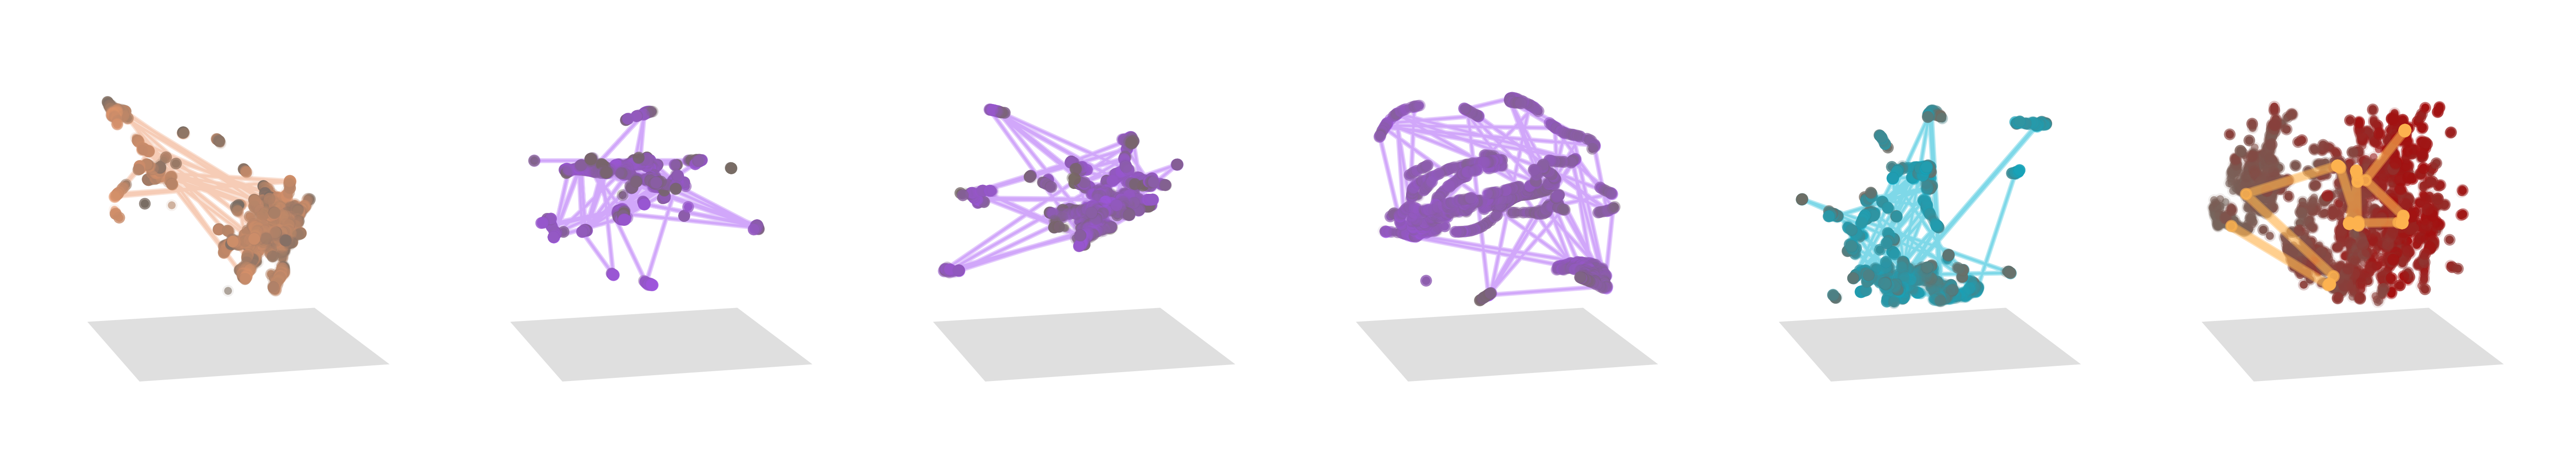

In [13]:
fig, axes = make_fig_like_plotly(
    acts_embeddings[start_story:end_story], acts_pos_labels[start_story:end_story],
    latent_embeddings['relu'][start_story:end_story], latent_pos_labels['relu'][start_story:end_story],
    latent_embeddings['topk'][start_story:end_story], latent_pos_labels['topk'][start_story:end_story],
    latent_embeddings['batchtopk'][start_story:end_story], latent_pos_labels['batchtopk'][start_story:end_story],
    novel_embeddings[start_story:end_story], novel_pos_labels[start_story:end_story],
    pred_embeddings[start_story:end_story], pred_pos_labels[start_story:end_story],
    elev=11, azim=-15,
    base_marker=10,
    connect_idx=0,
    viz_title=False
)
plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/stories_geometry.pdf', dpi=300)